In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, Linear, CFlow, FlowSequence
from flows.config import floatX
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [5]:
n = 32
s1 = 0.02
s0 = 0.45
dim = [3,4]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[-1] + np.random.normal(scale=s1, size=dim)
    params.append(new)
params = np.array(params, dtype=floatX)

PWalk = NormalRW(None, sigma=s1, sigma0=s0)

In [6]:
params.shape, params[0,0,0]

((32, 3, 4), 0.21214582367962187)

In [7]:
observ_std = 0.07

def autoregr(X, param):
    d = param[:,:3]
    X = np.matmul(d, X) + param[:,-1] + np.random.normal(size=[3], scale=observ_std)
    return X

def autoregr_tf(X, param):
    d = param[:,:3]
    X = tf.matmul(d, X)[:,0] + param[:,-1]
    return X

In [8]:
xs = [np.random.normal(size=dim[0])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.array(xs)[np.newaxis,:].astype(floatX)

In [9]:
xs

array([[[ 1.93464234e-01, -4.96744938e-01,  1.03272322e+00],
        [ 7.10603413e-01, -2.00919150e-01,  1.42183434e+00],
        [ 1.07420666e+00, -1.02354294e-01,  1.42958677e+00],
        [ 1.12812170e+00, -1.96849318e-01,  1.35667937e+00],
        [ 1.19191134e+00, -3.13971820e-01,  1.39904218e+00],
        [ 1.44836144e+00, -3.60622825e-01,  1.55039966e+00],
        [ 1.51738955e+00, -3.94575590e-01,  1.72697328e+00],
        [ 1.64518120e+00, -1.55751523e-01,  2.05954617e+00],
        [ 1.93182283e+00, -4.75234955e-03,  1.82964517e+00],
        [ 1.71150569e+00, -1.03043856e-01,  1.54524466e+00],
        [ 1.42083518e+00, -2.81987230e-01,  1.60378598e+00],
        [ 1.54145973e+00, -4.15680158e-01,  1.73974413e+00],
        [ 1.68464460e+00, -4.48550845e-01,  2.08756546e+00],
        [ 2.14688552e+00, -3.75741862e-01,  2.32043762e+00],
        [ 2.30865421e+00, -4.16004568e-01,  2.39870723e+00],
        [ 2.44590798e+00, -5.63656465e-01,  2.56920997e+00],
        [ 2.69030337e+00

In [10]:
# conf = [[ResFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)), 
#          NVPFlow(dim=n*dim[0]*dim[1], name='nvp{}'.format(i))] for i in range(2)]
# conf = sum(conf, [])

#conf = [NVPFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)) for i in range(4)]
conf = [Linear(dim=n*dim[0]*dim[1])]
# conf = [CFlow(dim=n*dim[0]*dim[1], name='CFlow')]

output_flow = DFlow(conf)

shape (1, 384)


In [11]:
output_flow.base.dim

[1, 384]

In [12]:
output_flow.output

<tf.Tensor 'LinFlow/add:0' shape=(1, 384) dtype=float64>

In [13]:
outputs = tf.reshape(output_flow.output, [1,n,dim[0]*dim[1]])

In [14]:
outputs

<tf.Tensor 'Reshape:0' shape=(1, 32, 12) dtype=float64>

In [15]:
prior = PWalk.logdens(outputs, mean=False)

In [16]:
#outputs = tf.cast(outputs, tf.float64)

In [17]:
prior

<tf.Tensor 'add_5:0' shape=() dtype=float64>

In [18]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=observ_std)
    out = tf.reshape(outputs, [n, 3, 4])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][:,np.newaxis], out[i])
        ll += obs_d.logdens(pred, full_reduce=True, mean=False)
    return ll

In [19]:
logl = create_loglik()

In [20]:
xs.shape

(1, 32, 3)

In [21]:
logl

<tf.Tensor 'add_98:0' shape=() dtype=float64>

In [22]:
ent = output_flow.logdens

In [23]:
ent

<tf.Tensor 'sub_1:0' shape=(1,) dtype=float64>

In [24]:
loss = -logl + ent - prior
loss /= n*dim[0]*dim[1]

In [25]:
opt = tf.train.AdamOptimizer(0.001).minimize(loss)

In [26]:
sess = tf.InteractiveSession()

In [27]:
tf.global_variables_initializer().run()

In [28]:
logl.eval(), prior.eval()

(-354412.2054560293, -1045889.3773148493)

In [29]:
loss.eval()

array([3527.10252086])

In [30]:
stage = 0

In [31]:
for stage in range(stage, stage+60):
    for _ in range(900):
        l, _ = sess.run([loss, opt], {phase:True})
    print(stage, l)

0 [1257.90138201]
1 [852.91734004]
2 [391.20371954]
3 [287.37311225]
4 [191.88890727]
5 [117.41870866]
6 [81.15389793]
7 [50.42880583]
8 [44.09821458]
9 [26.07027727]
10 [17.38469646]
11 [10.36974653]
12 [8.83546189]
13 [5.3422921]
14 [2.8070863]
15 [1.60355062]
16 [1.65597241]
17 [1.13124256]
18 [0.81044032]
19 [0.48534045]
20 [0.45662753]
21 [0.37159321]
22 [0.35625826]
23 [0.36380924]
24 [0.37903681]
25 [0.31705407]
26 [0.28381676]
27 [0.32315946]
28 [0.30283532]
29 [0.38145929]
30 [0.29358708]
31 [0.27339525]
32 [0.27952017]
33 [0.27315848]
34 [0.26670353]
35 [0.31974575]
36 [0.23512025]
37 [0.28158203]
38 [0.29735195]
39 [0.27354516]
40 [0.29464609]
41 [0.32013783]
42 [0.21283246]
43 [0.2743937]
44 [0.27015593]
45 [0.26686027]
46 [0.21896958]
47 [0.22715701]
48 [0.23692578]
49 [0.25072768]
50 [0.26741956]
51 [0.22842001]
52 [0.24139098]
53 [0.2296852]
54 [0.28845114]
55 [0.25425214]
56 [0.24686732]
57 [0.20882633]
58 [0.27447021]
59 [0.23764027]


In [32]:
out = tf.reshape(outputs, [n, 3, 4])

In [33]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [34]:
samples.shape

(1000, 32, 3, 4)

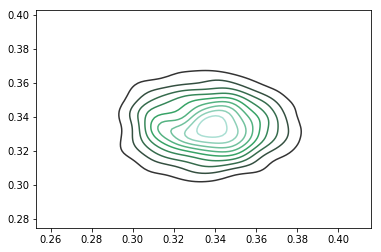

In [40]:
sns.kdeplot(samples[:,0,0,0], samples[:,1,0,0])
plt.show()

In [36]:
est = samples.mean(axis=0)

In [37]:
t = 16
a = params[t]
b = est[t]

In [38]:
a

array([[ 0.22971236, -0.61925557,  0.70763764, -0.15094097],
       [-0.38289507,  0.43885698,  0.39975687, -0.40450928],
       [ 0.08321515, -1.127141  ,  0.59731539,  0.47429672]])

In [39]:
b

array([[ 0.37074513, -0.28362124,  0.59875745,  0.08497264],
       [-0.15540275,  0.24372834,  0.04869914, -0.17548147],
       [ 0.18909729, -0.70868883,  0.60746717,  0.4256448 ]])